In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import yfinance as yf
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

sns.set_theme(style="whitegrid")

## EDA of the News Datasets

In [2]:
cnbc_data = pd.read_csv('dataset/cnbc_headlines.csv')
guardian_data = pd.read_csv('dataset/guardian_headlines.csv')
reuters_data = pd.read_csv('dataset/reuters_headlines.csv')

In [3]:
# Basic info for all three news headlines datasets
cnbc_info = cnbc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    2800 non-null   object
 1   Time         2800 non-null   object
 2   Description  2800 non-null   object
dtypes: object(3)
memory usage: 72.3+ KB


In [4]:
guardian_info = guardian_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17800 entries, 0 to 17799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       17800 non-null  object
 1   Headlines  17800 non-null  object
dtypes: object(2)
memory usage: 278.2+ KB


In [5]:
reuters_info = reuters_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32770 entries, 0 to 32769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Time         32770 non-null  object
 2   Description  32770 non-null  object
dtypes: object(3)
memory usage: 768.2+ KB


We can see here that all of the news datasets have varying numbers of data points ranging from 2800 to 32700. This will not be a problem for us since our question focuses on the impact of news headlines in general on the S&P 500, so all of this data will be combined in to a larger dataset ordered by the date of the headline. We can also see there is null data within the CNBC dataset which will be removed. 

In [6]:
cnbc_missing = cnbc_data.isnull().mean()
guardian_missing = guardian_data.isnull().mean()
reuters_missing = reuters_data.isnull().mean()

cnbc_missing, guardian_missing, reuters_missing

(Headlines      0.090909
 Time           0.090909
 Description    0.090909
 dtype: float64,
 Time         0.0
 Headlines    0.0
 dtype: float64,
 Headlines      0.0
 Time           0.0
 Description    0.0
 dtype: float64)

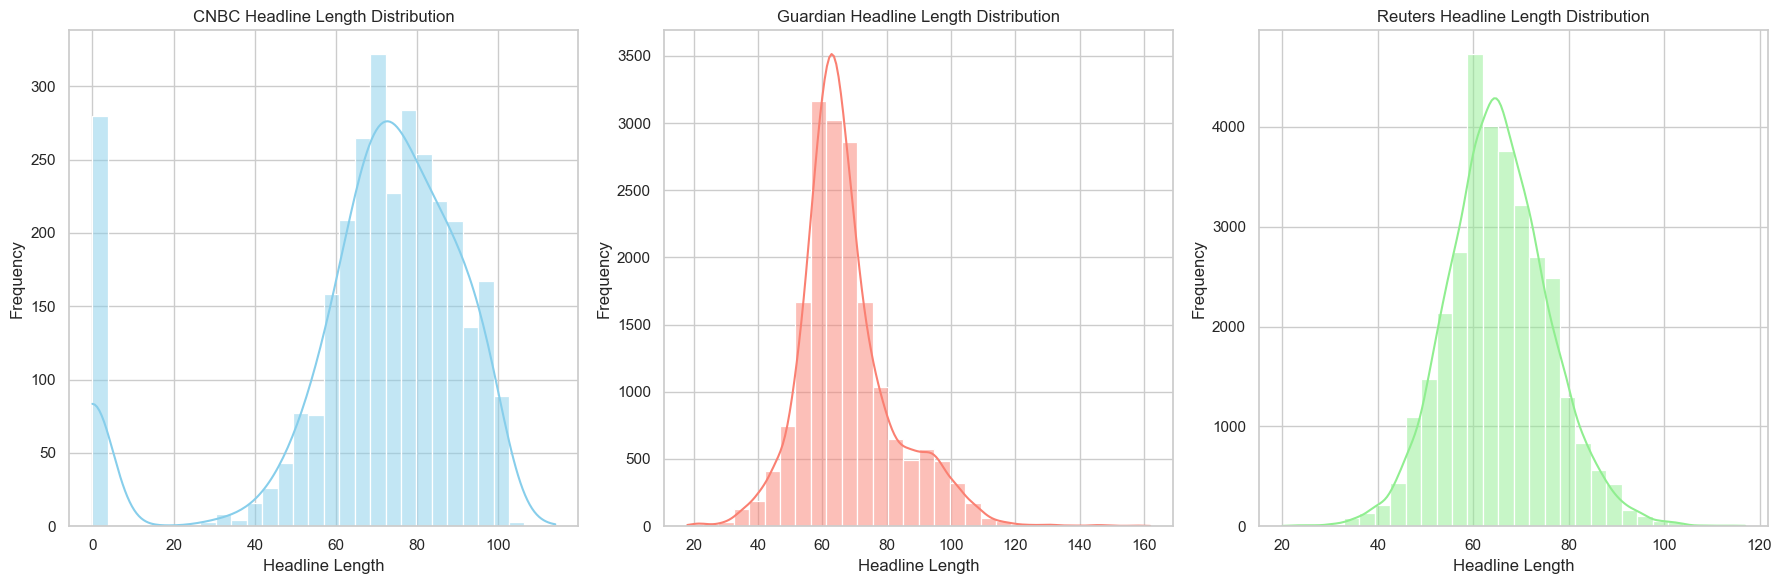

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# CNBC dataset
sns.histplot(cnbc_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[0], color="skyblue")
ax[0].set_title("CNBC Headline Length Distribution")
ax[0].set_xlabel("Headline Length")
ax[0].set_ylabel("Frequency")

# Guardian dataset
sns.histplot(guardian_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[1], color="salmon")
ax[1].set_title("Guardian Headline Length Distribution")
ax[1].set_xlabel("Headline Length")
ax[1].set_ylabel("Frequency")

# Reuters dataset
sns.histplot(reuters_data['Headlines'].fillna("").apply(len), bins=30, kde=True, ax=ax[2], color="lightgreen")
ax[2].set_title("Reuters Headline Length Distribution")
ax[2].set_xlabel("Headline Length")
ax[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


These histograms display the number of headlines given a specific length. Disregarding the bar at length of 0 in the CNBC graph due to the null data, headlines from all three stations seem to center around 60-70 words with the max being ~100 for CNBC and Reuters, and ~120 for the Guardian.

In [8]:
cnbc_data['Time'] = (
    cnbc_data['Time']
    .str.replace(r"ET", "", regex=True)
    .str.strip()  
)

# Convert the 'Time' columns to datetime format for each dataset
cnbc_data['Time'] = pd.to_datetime(cnbc_data['Time'], errors='coerce')
guardian_data['Time'] = pd.to_datetime(guardian_data['Time'], errors='coerce')
reuters_data['Time'] = pd.to_datetime(reuters_data['Time'], errors='coerce')

# Adding additional columns for time analysis
for df in [cnbc_data, guardian_data, reuters_data]:
    # Extract date parts for time-based analysis
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month

# Frequency of headlines by year and month for each dataset
cnbc_yearly_counts = cnbc_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)
guardian_yearly_counts = guardian_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)
reuters_yearly_counts = reuters_data.groupby(['Year', 'Month']).size().unstack(fill_value=0)


/var/folders/2f/pp48ygln7m9cxl6lrzd_n_t40000gn/T/ipykernel_44103/3364551870.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cnbc_data['Time'] = pd.to_datetime(cnbc_data['Time'], errors='coerce')
/var/folders/2f/pp48ygln7m9cxl6lrzd_n_t40000gn/T/ipykernel_44103/3364551870.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  guardian_data['Time'] = pd.to_datetime(guardian_data['Time'], errors='coerce')


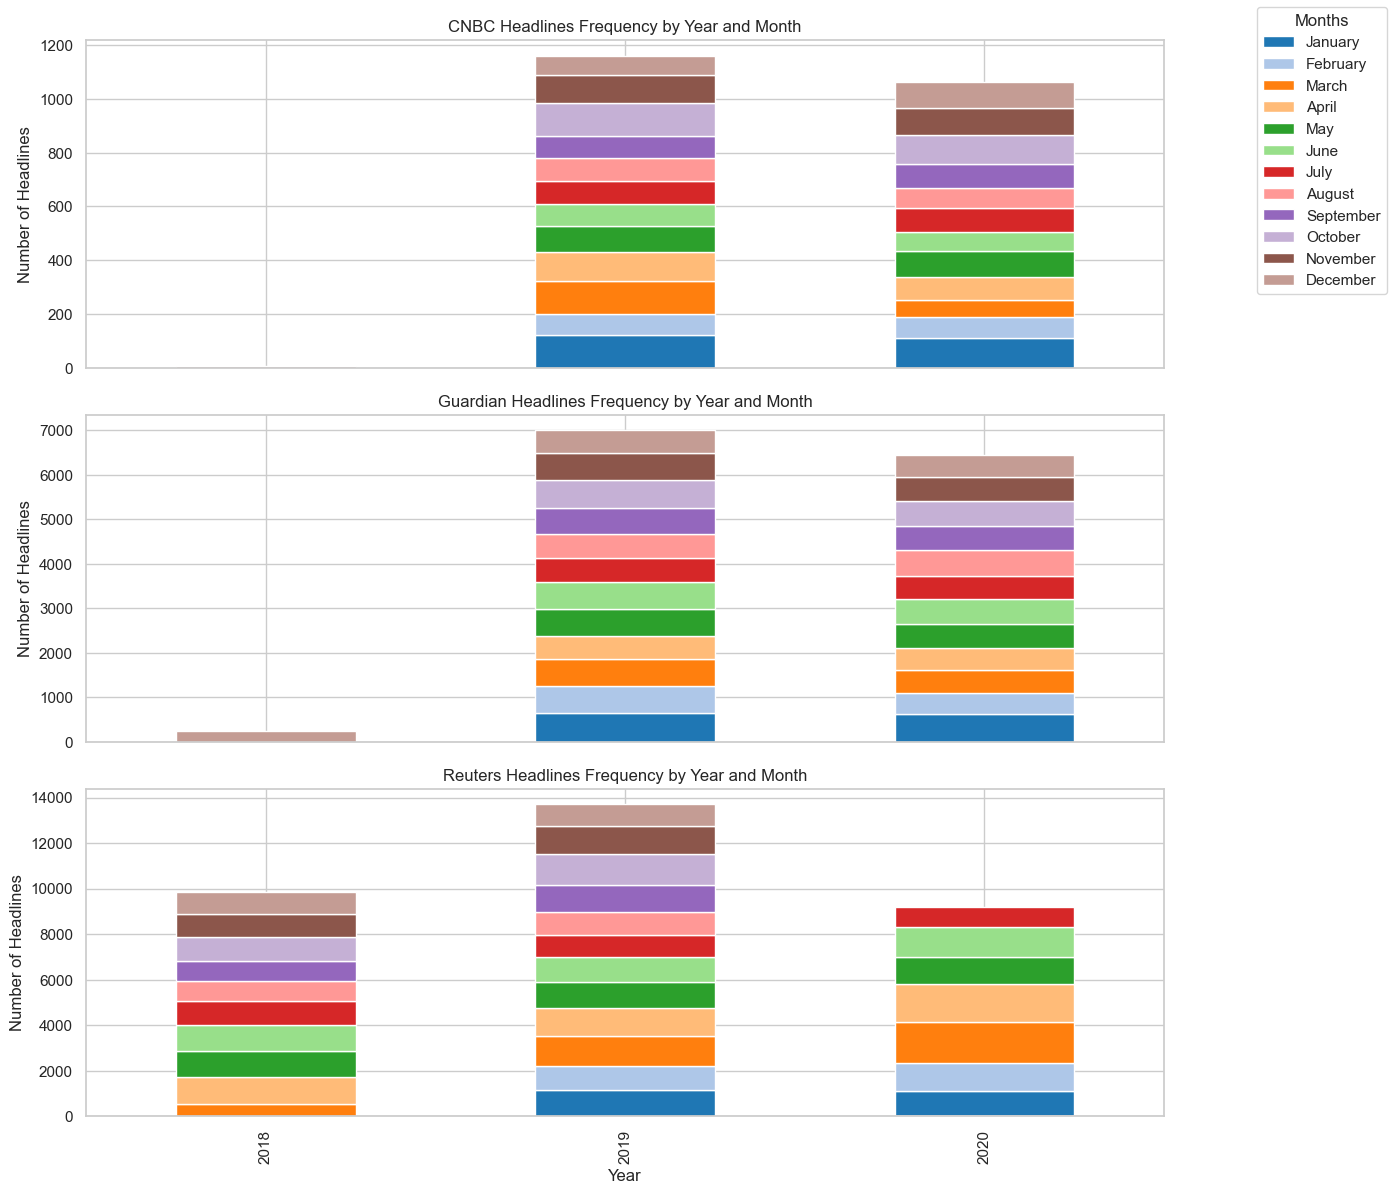

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Set a colormap to represent months consistently
month_colors = plt.colormaps["tab20"]

# CNBC dataset with month colors
cnbc_yearly_counts.plot(kind="bar", stacked=True, ax=ax[0], color=[month_colors(i) for i in range(12)], legend=False)
ax[0].set_title("CNBC Headlines Frequency by Year and Month")
ax[0].set_ylabel("Number of Headlines")

# Guardian dataset with month colors
guardian_yearly_counts.plot(kind="bar", stacked=True, ax=ax[1], color=[month_colors(i) for i in range(12)], legend=False)
ax[1].set_title("Guardian Headlines Frequency by Year and Month")
ax[1].set_ylabel("Number of Headlines")

# Reuters dataset with month colors
reuters_yearly_counts.plot(kind="bar", stacked=True, ax=ax[2], color=[month_colors(i) for i in range(12)], legend=False)
ax[2].set_title("Reuters Headlines Frequency by Year and Month")
ax[2].set_ylabel("Number of Headlines")
ax[2].set_xlabel("Year")

# Adding a single legend for the months
month_names = [calendar.month_name[i] for i in range(1, 13)]
fig.legend(month_names, loc="upper right", title="Months")
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit the legend
plt.show()

These graphs depict the number of headlines per month per year. With this, we can see that the earlier months of the year seem to have a higher concentration of headlines. 

In [10]:
# Remove extra data columns
for df in [cnbc_data, guardian_data, reuters_data]:
    df.drop(columns=['Year','Month'],inplace=True)

## Stock Price of the S&P 500

In [11]:
ticker = "^GSPC"
start_date = "2017-12-01"
end_date = "2020-07-31"

data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
data_hlcv = data[['High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [12]:
data_hlcv.head()

Price,High,Low,Close,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,
2017-12-01 00:00:00+00:00,2650.620117,2605.520020,2642.219971,3950930000
2017-12-04 00:00:00+00:00,2665.189941,2639.030029,2639.439941,4025840000
2017-12-05 00:00:00+00:00,2648.719971,2627.729980,2629.570068,3547570000
2017-12-06 00:00:00+00:00,2634.409912,2624.750000,2629.270020,3253080000
2017-12-07 00:00:00+00:00,2640.989990,2626.530029,2636.979980,3297060000


### Data Exploration

In [13]:
data_hlcv.describe()

Price,High,Low,Close,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC
count,669.000000,669.000000,669.000000,6.690000e+02
mean,2883.568308,2849.033738,2867.277964,3.965081e+09
std,198.117998,206.057495,202.285824,1.154337e+09
min,2300.729980,2191.860107,2237.399902,1.296530e+09
25%,2739.189941,2709.540039,2724.439941,3.300220e+09
50%,2856.669922,2825.389893,2843.489990,3.635780e+09
75%,2999.149902,2970.090088,2984.870117,4.156640e+09
max,3393.520020,3378.830078,3386.149902,9.053950e+09


In [14]:
missing_values = data_hlcv.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Price   Ticker
High    ^GSPC     0
Low     ^GSPC     0
Close   ^GSPC     0
Volume  ^GSPC     0
dtype: int64


The S&P 500 dataset from December 1, 2017, to July 31, 2020, contains **669** daily records with columns for `High`, `Low`, `Close`, and `Volume`, with **no missing values**. The average 'High', 'Low', and 'Close' prices are around 2883, 2849, and 2867, respectively, with standard deviations near 200 points, indicating moderate volatility. The 'Volume' data, averaging 3.97 billion shares, shows considerable variability, ranging from 1.3 billion to 9.05 billion, reflecting spikes in trading activity during certain market events.

To prepare for analysis, normalization or standardization may be beneficial to handle the scale differences, particularly between price and volume data. This initial overview confirms a relatively stable daily distribution, setting up further analysis on trends, volatility, and potential event impacts on S&P 500 performance.

### Close Price over Time

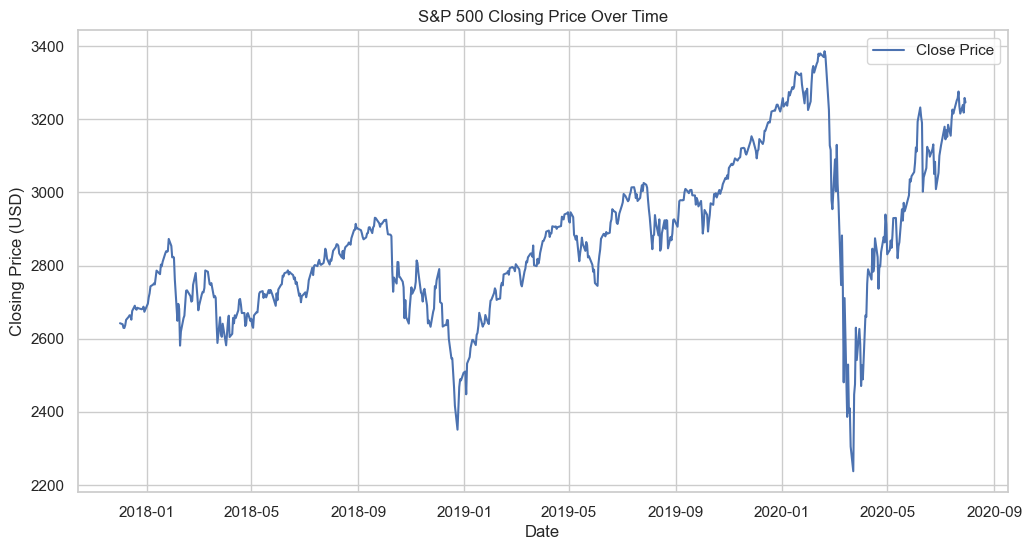

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data_hlcv.index, y=data_hlcv['Close'].squeeze(), color="#4c72b0", label="Close Price")
plt.title("S&P 500 Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.show()

This is the stock price of the S&P 500 over min and max dates covered by the news headlines. Some noticeable features that are included in this graph is the large dip during early 2020 caused by covid. This will have an interesting impact on our model since the news did play a big role in the scare factor for COVID-19, but the fact that it was caused by a global epidemic may skew the embeddings of other words.  

## News Headlines

In [16]:
df_gurdian = pd.read_csv('dataset/guardian_headlines.csv')
df_gurdian.head()

,Time,Headlines
0,18-Jul-20,Johnson is asking Santa for a Christmas recovery
1,18-Jul-20,‘I now fear the worst’: four grim tales of wor...
2,18-Jul-20,Five key areas Sunak must tackle to serve up e...
3,18-Jul-20,Covid-19 leaves firms ‘fatally ill-prepared’ f...
4,18-Jul-20,The Week in Patriarchy \n\n\n Bacardi's 'lad...


/var/folders/2f/pp48ygln7m9cxl6lrzd_n_t40000gn/T/ipykernel_44103/3014567614.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=counts, palette="Blues_d")  # Remove 'hue' argument


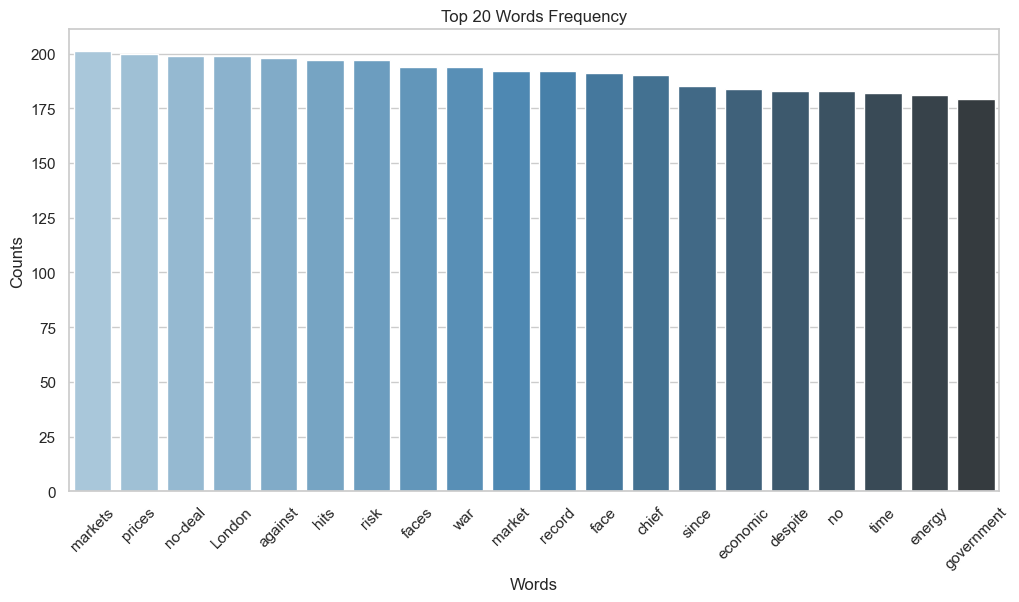

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create the word count dictionary
gurdian_string = ' '.join(guardian_data['Headlines'])  # Combine all headlines into one string
gurdian_string_list = gurdian_string.split(' ')  # Split the string into words

gurdian_count = {}

for word in gurdian_string_list:
    if word in gurdian_count:
        gurdian_count[word] += 1
    else:
        gurdian_count[word] = 1

# Step 2: Sort words by frequency and get the top 20 words
sorted_words = sorted(gurdian_count.items(), key=lambda item: item[1], reverse=True)
top_words = sorted_words[100:120]  # Select words from the 100th to the 120th most frequent

# Step 3: Create lists of words and their counts
words = [word for word, count in top_words]
counts = [count for word, count in top_words]

# Step 4: Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=words, y=counts, palette="Blues_d")  # Remove 'hue' argument
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top 20 Words Frequency')
plt.xticks(rotation=45)

plt.show()


This histogram captures a range of words and graphs them by the number of occurrences each one has. Currently words 100-120 are being displayed since many of the top words are meaningless words like articles, prepositions, pronouns, etc. The current graph has a few notable words like fears, energy, government, China, and shares. 

/var/folders/2f/pp48ygln7m9cxl6lrzd_n_t40000gn/T/ipykernel_44103/2496366710.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=counts, palette="Blues_d")  # Simple barplot without hue


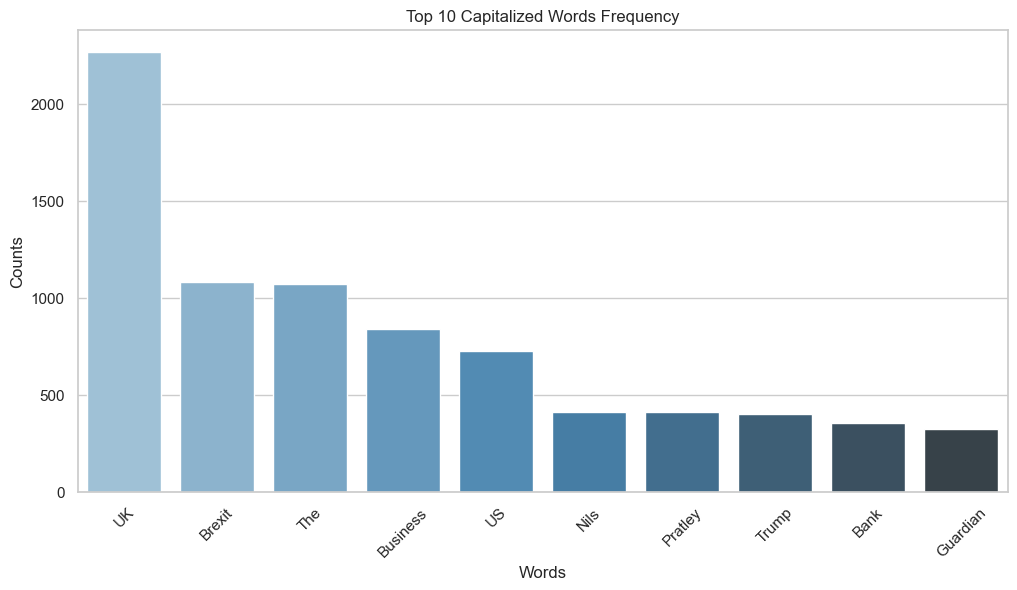

In [18]:
filtered_words = {word: count for word, count in gurdian_count.items() if any(c.isupper() for c in word)}
top_words = sorted(filtered_words.items(), key=lambda item: item[1], reverse=True)[:10]

# Extracting words and counts
words = [item[0] for item in top_words]
counts = [item[1] for item in top_words]

plt.figure(figsize=(12, 6))
sns.barplot(x=words, y=counts, palette="Blues_d")  # Simple barplot without hue
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top 10 Capitalized Words Frequency')
plt.xticks(rotation=45)
plt.show()


This graph is a more filtered version of the previous graph and only displays the top 10 words that start with a capital letter. This aims to get to most popular proper nouns that news headlines contain.  

## Data Preprocessing

### 1. Clean out the nulls

In [19]:
cnbc_cleaned = cnbc_data.dropna()

print("Original shape:", cnbc_data.shape)
print("Cleaned shape:", cnbc_cleaned.shape)

Original shape: (3080, 3)
Cleaned shape: (2800, 3)


In [20]:
# Drop rows with null values
guardian_cleaned = guardian_data.dropna()

# Convert 'Time' column to datetime, setting invalid dates to NaT
guardian_cleaned['Time'] = pd.to_datetime(guardian_cleaned['Time'], errors='coerce').dt.date

# Check the rows with NaT (invalid dates)
invalid_dates = guardian_cleaned[guardian_cleaned['Time'].isna()]
guardian_cleaned.dropna(subset=['Time'], inplace=True)

print("Original shape:", guardian_data.shape)
print("Cleaned shape:", guardian_cleaned.shape)

Original shape: (17800, 2)
Cleaned shape: (17760, 2)


/var/folders/2f/pp48ygln7m9cxl6lrzd_n_t40000gn/T/ipykernel_44103/2795643894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guardian_cleaned['Time'] = pd.to_datetime(guardian_cleaned['Time'], errors='coerce').dt.date
/var/folders/2f/pp48ygln7m9cxl6lrzd_n_t40000gn/T/ipykernel_44103/2795643894.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guardian_cleaned.dropna(subset=['Time'], inplace=True)


### 2. Removing extraneous columns

In [21]:
cnbc_data_cleaned = cnbc_cleaned.drop(columns=['Description'], errors='ignore')
reuters_cleaned = reuters_data.drop(columns=['Description'], errors='ignore')

print("CNBC dataset columns after cleaning:", cnbc_data_cleaned.columns)
print("Reuters dataset columns after cleaning:", reuters_cleaned.columns)
print("Guardian dataset columns after cleaning:", guardian_data.columns)

CNBC dataset columns after cleaning: Index(['Headlines', 'Time'], dtype='object')
Reuters dataset columns after cleaning: Index(['Headlines', 'Time'], dtype='object')
Guardian dataset columns after cleaning: Index(['Time', 'Headlines'], dtype='object')


### 3. Combine the three news dataset with stock data

In [22]:
stock_data = data_hlcv.reset_index()[['Date', 'Close']]

# Flatten the column headers if they are multi-level
stock_data.columns = stock_data.columns.map(lambda x: x[1] if isinstance(x, tuple) else x)
stock_data.rename(columns={stock_data.columns[0]: 'Date', stock_data.columns[1]: 'Close'}, inplace=True)

stock_data['trend_up'] = stock_data['Close'].shift(-1) > stock_data['Close']
stock_data.head()

,Date,Close,trend_up
0,2017-12-01 00:00:00+00:00,2642.219971,False
1,2017-12-04 00:00:00+00:00,2639.439941,False
2,2017-12-05 00:00:00+00:00,2629.570068,False
3,2017-12-06 00:00:00+00:00,2629.270020,True
4,2017-12-07 00:00:00+00:00,2636.979980,True


In [23]:
cnbc_data_cleaned['Date'] = pd.to_datetime(cnbc_data_cleaned['Time']).dt.date
guardian_cleaned['Date'] = pd.to_datetime(guardian_cleaned['Time']).dt.date
reuters_cleaned['Date'] = pd.to_datetime(reuters_cleaned['Time']).dt.date

cnbc_data_cleaned.drop(columns=['Time'],inplace=True)
guardian_cleaned.drop(columns=['Time'],inplace=True)
reuters_cleaned.drop(columns=['Time'],inplace=True)

stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

/var/folders/2f/pp48ygln7m9cxl6lrzd_n_t40000gn/T/ipykernel_44103/3131110233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guardian_cleaned['Date'] = pd.to_datetime(guardian_cleaned['Time']).dt.date
/var/folders/2f/pp48ygln7m9cxl6lrzd_n_t40000gn/T/ipykernel_44103/3131110233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guardian_cleaned.drop(columns=['Time'],inplace=True)


In [24]:
cnbc_data_cleaned.head()

,Headlines,Date
0,Jim Cramer: A better way to invest in the Covi...,2020-07-17
1,Cramer's lightning round: I would own Teradyne,2020-07-17
3,"Cramer's week ahead: Big week for earnings, ev...",2020-07-17
4,IQ Capital CEO Keith Bliss says tech and healt...,2020-07-17
5,Wall Street delivered the 'kind of pullback I'...,2020-07-16


In [25]:
# Concatenate datasets with stock data
cnbc_merged = pd.merge(cnbc_data_cleaned, stock_data, on='Date', how='inner')
cnbc_merged['Source'] = 'CNBC'
guardian_merged = pd.merge(guardian_cleaned, stock_data, on='Date', how='inner')
guardian_merged['Source'] = 'Guardian'
reuters_merged = pd.merge(reuters_cleaned, stock_data, on='Date', how='inner')
reuters_merged['Source'] = 'Reuters'

# Combine all datasets into one
final_dataset = pd.concat([cnbc_merged, guardian_merged, reuters_merged])

In [ ]:
final_dataset.to_csv("dataset/final_dataset.csv", index=False) 
final_dataset.head()

,Headlines,Date,Close,trend_up,Source
0,Jim Cramer: A better way to invest in the Covi...,2020-07-17,3224.729980,True,CNBC
1,Cramer's lightning round: I would own Teradyne,2020-07-17,3224.729980,True,CNBC
2,"Cramer's week ahead: Big week for earnings, ev...",2020-07-17,3224.729980,True,CNBC
3,IQ Capital CEO Keith Bliss says tech and healt...,2020-07-17,3224.729980,True,CNBC
4,Wall Street delivered the 'kind of pullback I'...,2020-07-16,3215.570068,True,CNBC


### 4. Tokenize

In [30]:
# Preprocess the text - clean the headlines
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # remove non-word characters
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    return text.strip()

final_dataset['cleaned_headlines'] = final_dataset['Headlines'].apply(preprocess_text)

# Tokenize - Create a vocabulary (word to integer mapping)
all_words = ' '.join(final_dataset['cleaned_headlines']).split()
vocab = {word: idx + 1 for idx, word in enumerate(set(all_words))}  # map words to unique integers

# Tokenize the dataset - convert each word in a headline to its corresponding integer
def tokenize(text, vocab):
    return [vocab[word] for word in text.split() if word in vocab]

final_dataset['tokenized_headlines'] = final_dataset['cleaned_headlines'].apply(lambda x: tokenize(x, vocab))

final_dataset[['Headlines', 'tokenized_headlines']].head()

,Headlines,tokenized_headlines
0,Jim Cramer: A better way to invest in the Covi...,"[20281, 2152, 2495, 17958, 6795, 6156, 22075, ..."
1,Cramer's lightning round: I would own Teradyne,"[2152, 11274, 21377, 5475, 7020, 15181, 12176,..."
2,"Cramer's week ahead: Big week for earnings, ev...","[2152, 11274, 13159, 15331, 5385, 13159, 641, ..."
3,IQ Capital CEO Keith Bliss says tech and healt...,"[20338, 8270, 10813, 21823, 1630, 18860, 6686,..."
4,Wall Street delivered the 'kind of pullback I'...,"[3245, 7498, 14664, 19323, 4540, 15886, 20438,..."


In [31]:
embedding_size = 50
embedding_matrix = {}

for word, idx in vocab.items():
    embedding_matrix[word] = np.random.randn(embedding_size)  # Random vector for each word

embedding_df = pd.DataFrame.from_dict(embedding_matrix, orient='index')
embedding_df.head()


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
tokyo,-0.909038,0.111714,0.135844,0.121991,0.069522,0.609672,0.520555,0.163394,-2.255451,0.741887,...,-0.665506,0.380471,-1.134920,-0.685470,0.243377,1.456608,1.768986,-0.763700,0.560469,1.925293
duchess,-0.278158,-1.861978,-0.118346,0.054485,0.715117,0.424026,-1.554302,1.111206,-0.402495,-0.653515,...,1.354530,-1.375424,-0.633204,0.584586,-1.347454,-0.792132,-0.311770,0.430932,0.858771,-0.409338
34,0.055202,1.283158,1.030810,-0.328384,-2.383228,-0.028978,-1.315927,0.165481,-0.867256,-1.048737,...,-0.716132,-0.015412,-0.438219,0.248095,-1.152182,0.689959,-0.970720,-0.416782,0.537282,-1.279187
paradigm,0.697029,0.346426,-0.199971,-0.927646,-1.070653,-1.586408,0.043306,2.050311,-1.032778,-0.231333,...,0.052561,-0.442062,-0.137786,1.740333,-0.072000,-1.308064,-2.409543,-1.432540,0.153129,-0.524008
mexican,1.595857,-0.747090,-1.675548,-0.361689,-0.497321,0.679887,-0.216000,-0.776304,-0.345032,2.082012,...,0.465328,1.136096,1.121448,0.170850,0.532376,-0.556703,-0.983512,-0.212872,-1.781229,-2.542501


## First Model

In [27]:
# Prepare headlines column for TF-IDF
def clean_headlines(data):
    # Lower case all values
    data.loc[:, 'Headlines'] = data['Headlines'].apply(lambda x: x.lower())
    # Remove special characters and numbers
    data.loc[:, 'Headlines'] = data['Headlines'].apply(lambda x: re.sub(r'[^a-z\s]', ' ', x))
    # Remove extra spaces
    data.loc[:, 'Headlines'] = data['Headlines'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

In [31]:
# Clean headlines
temp_df = final_dataset.copy()
clean_headlines(temp_df)

#Group by date and concat all headlines into one str for each day
grouped_dataset = temp_df.groupby('Date').agg(
    Headlines=('Headlines', ' '.join), 
    trend_up=('trend_up', 'first') 
).reset_index()

In [35]:
# First Model: Logistic Regression Model with TF-IDF features
data = grouped_dataset[['Headlines', 'trend_up']].copy()

vectorizer = TfidfVectorizer(max_features=800)  # Limit to top 800 features for simplicity
X = vectorizer.fit_transform(data['Headlines']).toarray()
y = data['trend_up'].astype(int).values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(random_state=42, max_iter=1500)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Display results
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:", train_accuracy)
print("\nClassification Report(Test):\n", classification_report(y_test, y_pred_test))

Test Accuracy: 0.6384615384615384
Train Accuracy: 0.7620889748549323

Classification Report(Test):
               precision    recall  f1-score   support

           0       0.63      0.31      0.42        54
           1       0.64      0.87      0.74        76

    accuracy                           0.64       130
   macro avg       0.64      0.59      0.58       130
weighted avg       0.64      0.64      0.61       130



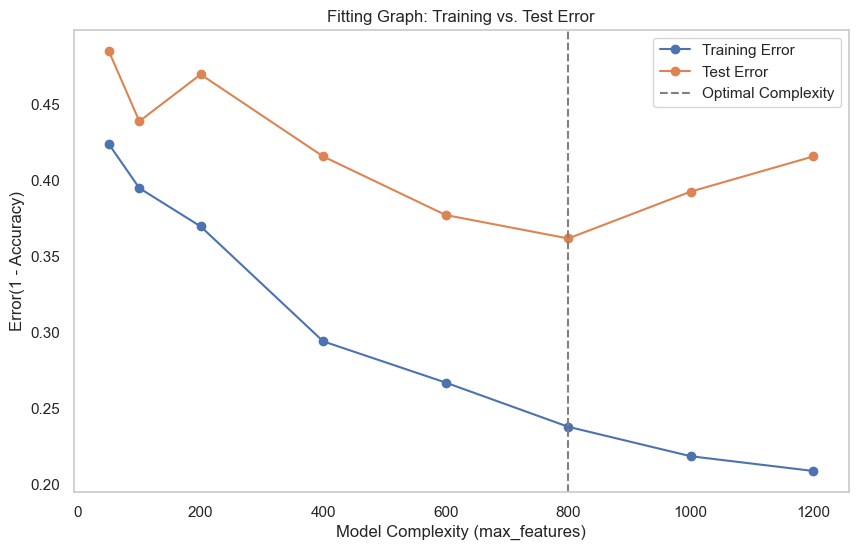

In [37]:
# Define a range of max_features values to represent model complexity
complexities = [50, 100, 200, 400, 600, 800, 1000, 1200]
train_errors = []
test_errors = []

for max_features in complexities:
    # Create TF-IDF vectorizer with the current max_features
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(data['Headlines']).toarray()
    y = data['trend_up'].astype(int).values
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train logistic regression model
    model = LogisticRegression(random_state=42, max_iter=1500)
    model.fit(X_train, y_train)
    
    # Predict and compute errors
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    train_errors.append(1 - train_accuracy)
    test_errors.append(1 - test_accuracy)

# Plotting the fitting graph
plt.figure(figsize=(10, 6))
plt.plot(complexities, train_errors, label="Training Error", marker='o')
plt.plot(complexities, test_errors, label="Test Error", marker='o')
plt.axvline(x=complexities[np.argmin(test_errors)], linestyle='--', color='gray', label="Optimal Complexity")
plt.title("Fitting Graph: Training vs. Test Error")
plt.xlabel("Model Complexity (max_features)")
plt.ylabel("Error(1 - Accuracy)")
plt.legend()
plt.grid()
plt.show()
